In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_408.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_222.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_200.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_285.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_210.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_243.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_214.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_323.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_320.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_272.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_309.jpg
/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset/metal/metal_343.jpg
/kag

1.IMPORTING NECESSARY LIBRARIES

In [4]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
!pip install gradio
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 83.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.1 MB/s eta 0:00:00


2.EXPLORE AND UNDERSTAND THE DATA
Load image dataset using tools like image_dataset_from_directory.
Split data into training, validation, and testing sets.

In [14]:
dataset_dir= r"/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [16]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [17]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
# Use `skip` on the *original* val_ds to get the remaining validation data
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# Optimize validation dataset for evaluation
val_dat_eval = val_dat.cache().prefetch(tf.data.AUTOTUNE)

In [18]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


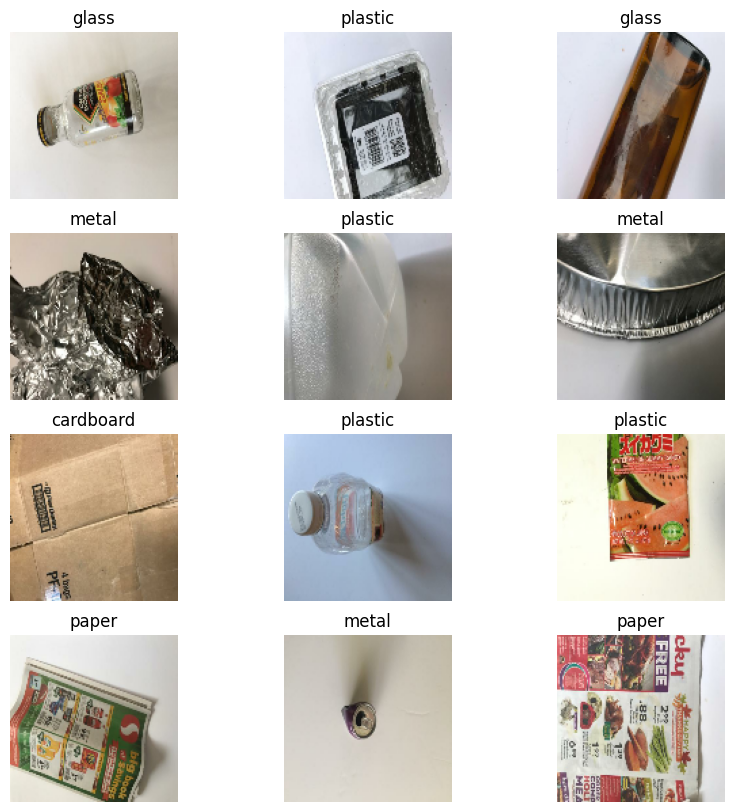

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

Check the number of images per class to ensure balance & 
Understand image properties like Image dimensions, Class labels

In [20]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage
    return counts
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [21]:
class_names = train_ds.class_names

# Get class distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_dat_eval, class_names) # Use val_dat_eval for distribution counting
test_dist = count_distribution(test_ds_eval, class_names) # Use test_ds_eval for distribution counting
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 12.45, 'glass': 23.69, 'metal': 16.06, 'paper': 23.29, 'plastic': 18.88, 'trash': 5.62}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 14.48, 'glass': 21.71, 'metal': 15.99, 'paper': 23.29, 'plastic': 19.16, 'trash': 5.36}


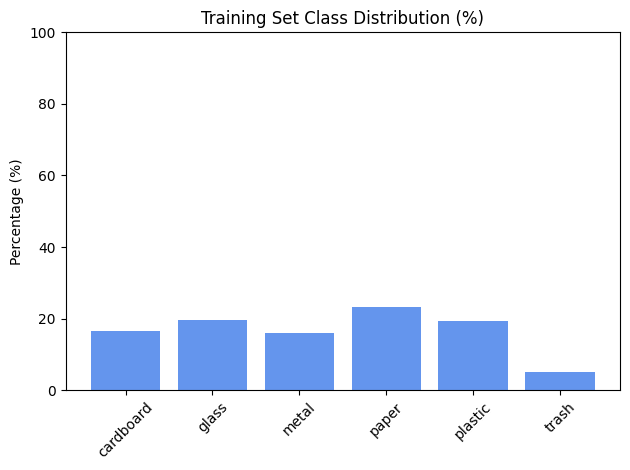

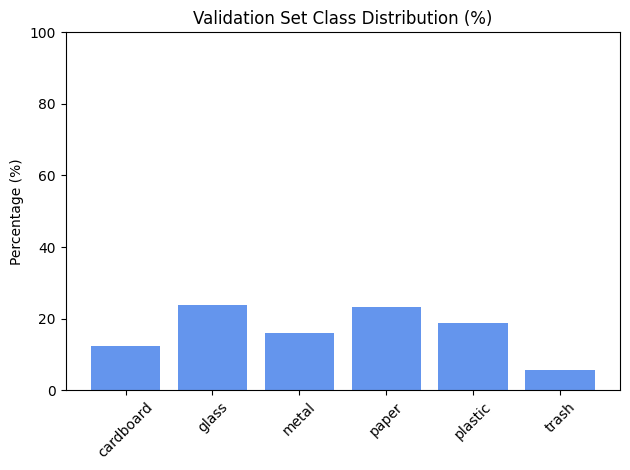

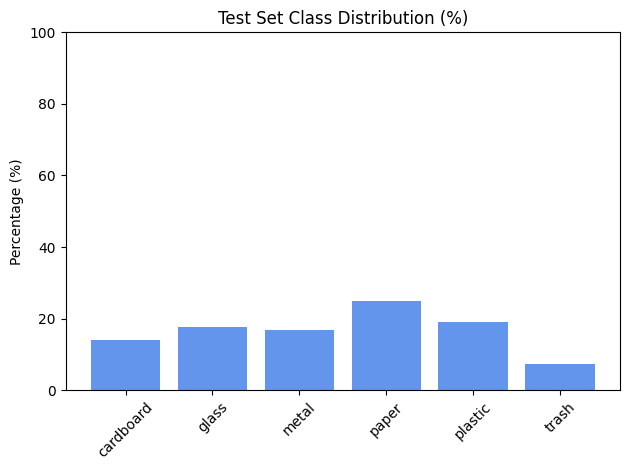

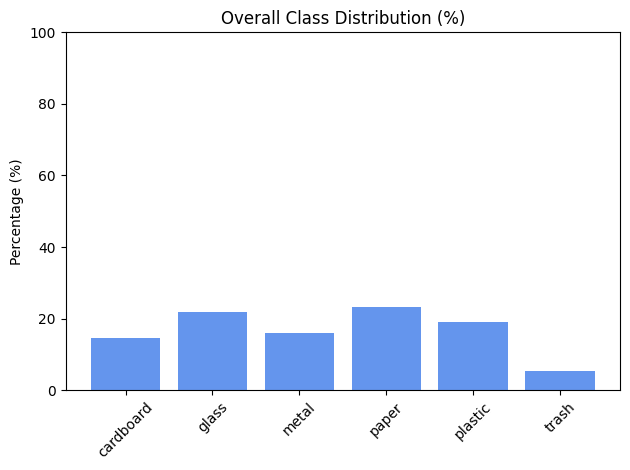

In [22]:
# Show visualizations
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [23]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}
# ✅ Optional: print results
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


3.DATA PREPROCESSING / PREPARATION

In [25]:
#  Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

4.MODEL SELECTION

In [27]:
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')


#  Freeze early layers (to retain general pretrained features)
base_model.trainable = True
for layer in base_model.layers[:100]:  # You can adjust this number
    layer.trainable = False

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


5.MODEL TRAINING, TUNING AND OPTIMIZATION

In [28]:
#  Build the final model
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # Change to your number of classes
])
# ⚙️ Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [30]:
# Set the number of epochs to train the model
epochs = 15  # Number of times the model will go through the entire dataset

# Train the model using the fit function
history = model.fit(
    train_ds,                # Training dataset used to adjust model weights
    validation_data=val_dat_eval,   # Validation dataset to monitor performance on unseen data
    epochs=epochs,           # Number of training cycles, referencing the variable set earlier
    class_weight=class_weights,  # Handles class imbalances by assigning appropriate weights
    batch_size=32,           # Number of samples processed in each training step
    callbacks=[early]        # Implements early stopping to prevent unnecessary training
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 119s 934ms/step - accuracy: 0.3072 - loss: 1.6960 - val_accuracy: 0.6145 - val_loss: 1.1847
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 850ms/step - accuracy: 0.6546 - loss: 1.0756 - val_accuracy: 0.7590 - val_loss: 0.8319
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 867ms/step - accuracy: 0.7748 - loss: 0.7291 - val_accuracy: 0.8313 - val_loss: 0.6218
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 850ms/step - accuracy: 0.8327 - loss: 0.5091 - val_accuracy: 0.8394 - val_loss: 0.5453
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 836ms/step - accuracy: 0.8689 - loss: 0.3839 - val_accuracy: 0.8514 - val_loss: 0.4641
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 821ms/step - accuracy: 0.9009 - loss: 0.2865 - val_accuracy: 0.8635 - val_loss: 0.4358
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 828ms/step - accuracy: 0.9373 - loss: 0.2246 - val_accuracy: 0.8755 - val_loss: 0.3860
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 828ms/step - accuracy: 0.9388 - loss: 0.2015 - val_acc

In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 4, 4, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [32]:
base_model.summary() 

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 124, 124, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 124, 124, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 124, 124, 3)    │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 62, 62, 32)     │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 62, 62, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 62, 62, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 62, 62, 16)     │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 62, 62, 16)     │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 62, 62, 16)     │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 62, 62, 16)     │          2,304 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 62, 62, 16)     │             64 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 62, 62, 16)     │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 62, 62, 16)     │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 62, 62, 16)     │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_project_activ… │
├──────────────────────

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

MODEL PERFORMANCE VISUALIZATION : ACCURACY & LOSS TRENDS

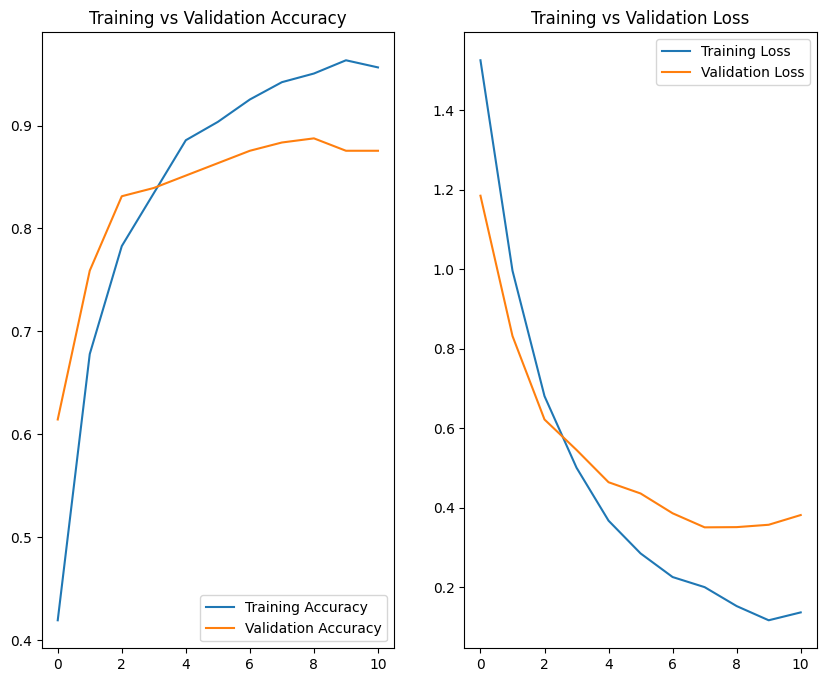

In [33]:
acc = history.history['accuracy']          # Extract training accuracy from history
val_acc = history.history['val_accuracy']  # Extract validation accuracy from history
loss = history.history['loss']             # Extract training loss from history
val_loss = history.history['val_loss']     # Extract validation loss from history

epochs_range = range(len(acc))             # Define range for epochs based on accuracy length

plt.figure(figsize=(10,8))                 # Set overall figure size for visualization

plt.subplot(1,2,1)                         # Create first subplot (1 row, 2 columns, position 1)
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Place legend in lower-right corner
plt.title('Training vs Validation Accuracy') # Add title for accuracy plot

plt.subplot(1,2,2)                         # Create second subplot (1 row, 2 columns, position 2)
plt.plot(epochs_range, loss, label='Training Loss')         # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')   # Plot validation loss
plt.legend(loc='upper right')              # Place legend in upper-right corner
plt.title('Training vs Validation Loss')   # Add title for loss plot

plt.show()                                 # Display the plots


MODEL EVALUATION

In [34]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.9482 - loss: 0.1968
Test accuracy is0.9180, Test loss is 0.2602


In [35]:
# Extract true labels from all batches in the test dataset
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  # Convert Tensor labels to NumPy array and concatenate them

# Get predictions as probabilities from the model
y_pred_probs = model.predict(test_ds_eval)  # Predict class probabilities for each sample in the test dataset

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Select the class with the highest probability for each sample

# Compute the confusion matrix to evaluate classification performance
cm = confusion_matrix(y_true, y_pred)  # Generate confusion matrix comparing true labels to predicted labels

# Print metrics to assess model performance
print(cm)  # Display confusion matrix
print(classification_report(y_true, y_pred))  # Print precision, recall, and F1-score for each class

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step
[[32  0  0  4  0  0]
 [ 0 38  4  0  3  0]
 [ 0  1 41  0  0  1]
 [ 1  0  0 62  0  1]
 [ 0  0  1  0 45  3]
 [ 0  1  1  0  0 17]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93        36
           1       0.95      0.84      0.89        45
           2       0.87      0.95      0.91        43
           3       0.94      0.97      0.95        64
           4       0.94      0.92      0.93        49
           5       0.77      0.89      0.83        19

    accuracy                           0.92       256
   macro avg       0.91      0.91      0.91       256
weighted avg       0.92      0.92      0.92       256



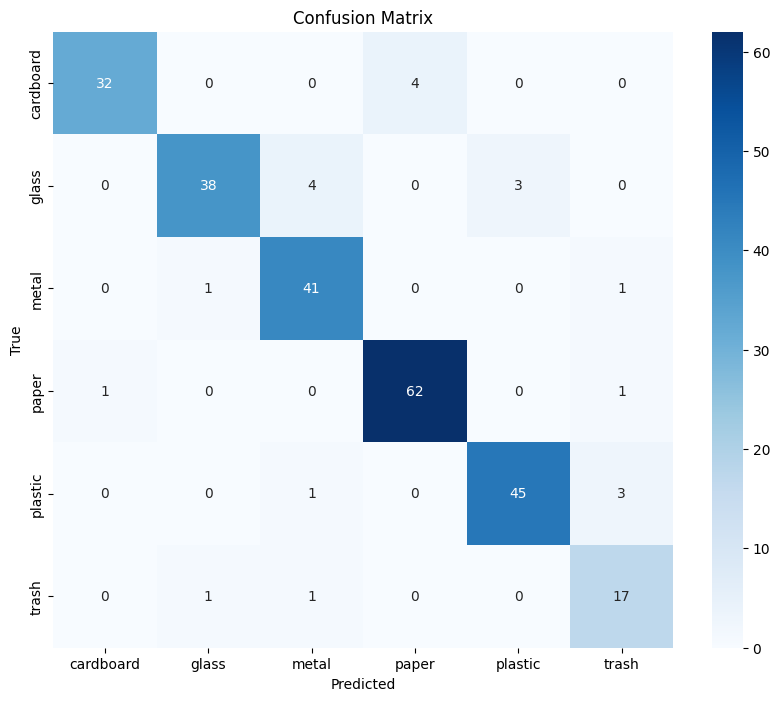

In [36]:
plt.figure(figsize=(10,8))  # Set figure size for better visualization

sns.heatmap(cm, annot=True, fmt='d',  # Create heatmap using confusion matrix
            xticklabels=class_names,  # Set class names for x-axis (predicted labels)
            yticklabels=class_names,  # Set class names for y-axis (true labels)
            cmap='Blues')  # Use a blue colormap for better contrast

plt.xlabel('Predicted')  # Label x-axis as Predicted classes
plt.ylabel('True')  # Label y-axis as True classes
plt.title('Confusion Matrix')  # Add title to the heatmap
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


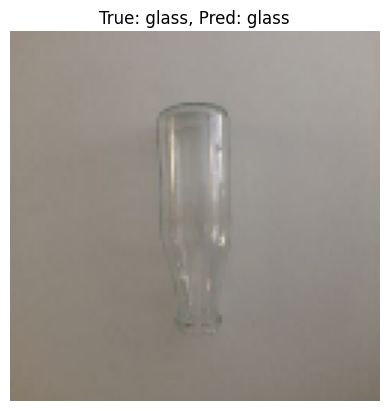

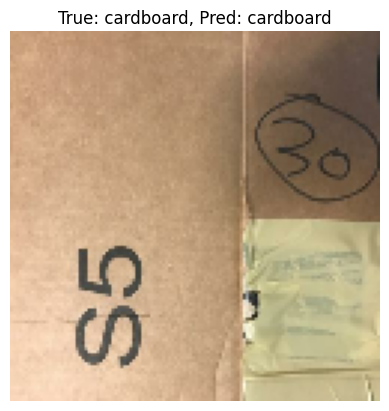

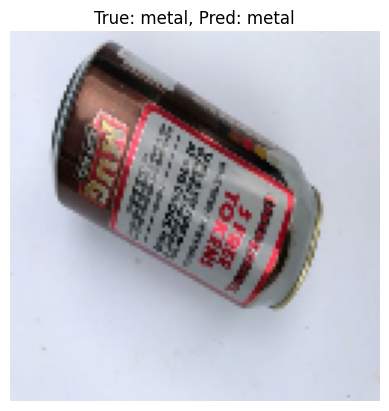

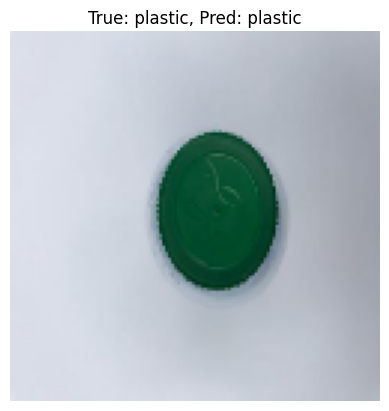

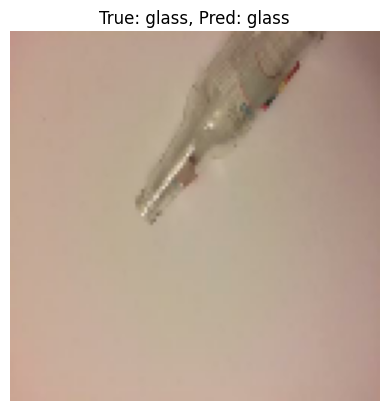

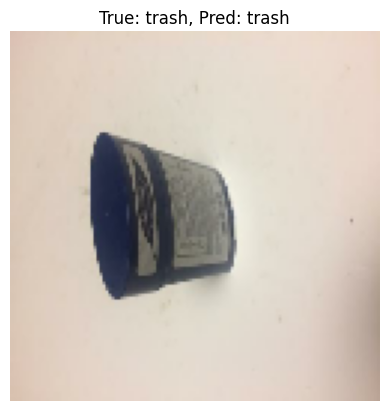

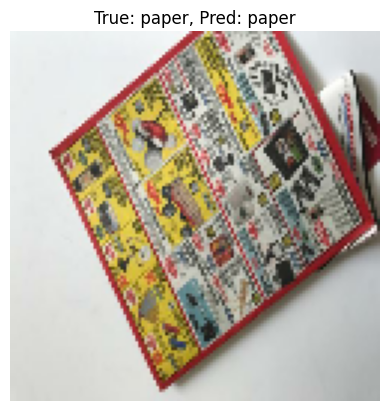

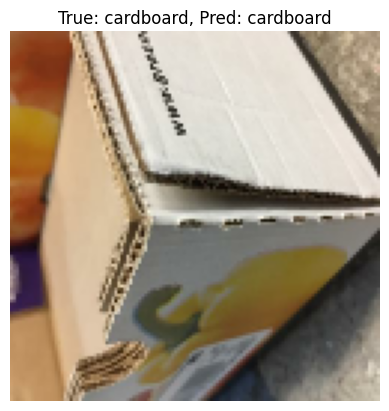

In [37]:
# Extract class names from the training dataset
class_names = train_ds.class_names  

# Take one batch of images and labels from the test dataset for evaluation
for images, labels in test_ds_eval.take(1):  

    # Generate predictions for the batch of images
    predictions = model.predict(images)  

    # Get the predicted class index for each image
    pred_labels = tf.argmax(predictions, axis=1)  

    # Loop through the first 8 images in the batch
    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert and display image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Show actual and predicted class
        plt.axis("off")  # Hide axes for better visualization
        plt.show()  # Display the image with title

In [38]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')